pip install dash
pip install dash-bootstrap-components
pip install dash-mantine-components==0.12.1
pip install dash-holoniq-wordcloud

**SATISFACTION CLIENT SENTIMENT ANALYSIS AND DASHBOARD**

In [102]:
# Import packages
import dash
from dash import Dash, html, dash_table, dcc, callback, Output, Input
from dash_holoniq_wordcloud import DashWordcloud
import pandas as pd
import plotly.express as px
import dash_bootstrap_components as dbc
import re
import numpy as np
import datetime
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import warnings
warnings.filterwarnings("ignore")
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


**Load data**

In [103]:
#Load company infos
df = pd.read_csv(r"D:\PROFIL\BCRK1417\Documents\Parcours_FEST\work\codes\de_satisfaction_client\data\informations_entreprises.csv", sep=',',decimal='.')

# Load comments per company
df_comments = pd.read_json(r"D:\PROFIL\BCRK1417\Documents\Parcours_FEST\work\codes\de_satisfaction_client\data\df_commentaires_par_entreprise.json")

df.head(3)

,town,country,institution_type,company_name,trust_score,review,five_star_%
0,Portland,United States,Financial Institution,Evergreen Credit Union,4.9,340,96%
1,Lincoln,United States,ATM,Liberty First Credit Union,4.7,304,92%
2,Irvine,United States,ATM,GoHenry by Acorns,4.3,3300,66%


**Data cleanning/Preprocessing**

In [104]:
from sklearn.impute import SimpleImputer
import numpy as np

def company_preprocessing(df):
    #rename col
    df.rename(columns={"review": "nombre_reviews"}, inplace=True)

    #remove white spaces
    df.town =df.town.apply(lambda x: str(str(x).strip().upper()).replace('nan', 'NaN').replace('NAN','NaN'))
    df.country =df.country.apply(lambda x: str(str(x).strip()).replace('nan', 'NaN'))
    df.institution_type =df.institution_type.apply(lambda x: str(str(x).strip()).replace('nan', 'NaN'))

    #replace Nan with most frequent
    imputer = SimpleImputer(missing_values='NaN', strategy='most_frequent')
    df.loc[:,['town','country','institution_type']] = imputer.fit_transform(df[['town','country','institution_type']])

    #replace trust_score,nombre_reviews,five_star_%; nan by zero
    df['trust_score'] = df['trust_score'].fillna(0)
    df['five_star_%'] = df['five_star_%'].fillna(0)
    df['five_star_%']= df['five_star_%'].apply(lambda x: str(x).replace('0','0%') if len(str(x))==1 else x)
    df['nombre_reviews'] = df['nombre_reviews'].fillna(0)

    #Short company_name
    df['short_company_name'] = df['company_name']
    df['company_name']= df['short_company_name'].apply(lambda x: str(x).strip()[:7] + "...")
    
    return df



In [105]:
df = company_preprocessing(df)
df.head(3)


,town,country,institution_type,company_name,trust_score,nombre_reviews,five_star_%,short_company_name
0,PORTLAND,United States,FiNaNcial Institution,Evergre...,4.9,340,96%,Evergreen Credit Union
1,LINCOLN,United States,ATM,Liberty...,4.7,304,92%,Liberty First Credit Union
2,IRVINE,United States,ATM,GoHenry...,4.3,3300,66%,GoHenry by Acorns


**Sentiment Analysis**

In [106]:
def company_comment_processing(df_comments):

    df_comments['company_name']= df_comments['company_name'].apply(lambda x: str(x).strip()[:11] + "...")

    text_df = df_comments.drop(['User', 'localisation', 'Titre','nombre_reviews', 'date_experience', 'reply'
           ], axis=1)
           
    text_df.rename(columns={'commentaire': 'text'}, inplace=True)
    #text_df.head()

    return text_df

#Comment processing
def comments_preprocessing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]

    return " ".join(filtered_text)

#Stream word

stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

#Polarity fxn
def polarity(text):
    return TextBlob(text).sentiment.polarity

#Comment status
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"


def comment_polarity(text_df):
    
    #text_df.text = text_df['text'].apply(comments_preprocessing)
    text_df = text_df.drop_duplicates('text')

    #apply streamer
    text_df['text'] = text_df['text'].apply(lambda x: stemming(x))

    #compute polarity
    text_df['polarity'] = text_df['text'].apply(polarity)

    #Detect comment polarity
    text_df['sentiment'] = text_df['polarity'].apply(sentiment)

    return text_df


def compute_sentiment_analysis(df_comments):

    text_df = company_comment_processing(df_comments)

    df_polarity =pd.DataFrame()

    for company in text_df.company_name.unique():
        text_df[text_df.company_name==company]
        comp_pol =comment_polarity(text_df[text_df.company_name==company])
        comp_pol['company_name']= company
        df_polarity= pd.concat([df_polarity,comp_pol])

    #fig = plt.figure(figsize=(5,5))
    #sns.countplot(x='sentiment', data = df_polarity)
    return df_polarity


def get_company_sentiment_count_per_year(df_comments, df_polarity):

    df_comments.rename(columns={"commentaire": "text"}, inplace=True)
    df_p = df_polarity.merge(df_comments[['year', 'company_name','text']], on=['text', 'company_name'], how='left')
    
    # Group by company_name, year, and sentiment, then count the occurrences
    grouped_df = df_p.groupby(['company_name', 'year', 'sentiment']).size().unstack(fill_value=0)
    
    # Reset the index to make the DataFrame more readable
    grouped_df = grouped_df.reset_index()

    #print(grouped_df.head())

    return grouped_df


**Dashboards**

In [107]:

warnings.filterwarnings("ignore")
# Load data
#df = pd.read_csv('atm_company_info.csv')

# Initialize Dash app

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])


################################################################################################################
###### Company Analysis Figures
################################################################################################################
# Map Visualization
#map_fig = px.scatter_mapbox(df, lat='latitude', lon='longitude', hover_name='company_name',
#                            color='trust_score', size='trust_score',
#                            mapbox_style="carto-positron", zoom=3, height=500)

# Company Trust Score Bar Chart
trust_fig = px.bar(df, y='company_name', x='trust_score', color='trust_score', title="Trust Score by Company")
trust_fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'}, height=500)

# Institution Type Pie Chart
institution_fig = px.pie(df, names='institution_type', title="Institution Type Distribution")

# Review Distribution Histogram
# Remove the '%' sign and convert to numeric type
df['five_star_%'] = df['five_star_%'].str.rstrip('%').astype('float')
df = df.sort_values('five_star_%')
df['five_star_%'] = df['five_star_%'].astype(str) + '%'
review_dist_fig = px.histogram(df, x='five_star_%', title="Review Distribution", color='five_star_%')

# Top Reviewed Companies
top_companies_fig = px.bar(df.sort_values(by='nombre_reviews', ascending=False).head(10), 
                           x='company_name', y='nombre_reviews', title="Top Reviewed Companies")

# Company Comparison Radar Chart (trust_score vs five_star_%)
df_melt = pd.melt(df, id_vars=['company_name'], value_vars=['trust_score', 'five_star_%'])
comparison_fig = px.line_polar(df_melt, r='value', theta='variable', color='company_name', 
                               line_close=True, title="Company Comparison")




################################################################################################################
###### Comment Sentiment Analysis 
################################################################################################################
#print(" Comment Sentiment Analysis")


# Example sentiment analysis - dummy data
#df_comments['sentiment'] = df_comments['commentaire'].apply(lambda x: 'Positive' if 'good' in x else 'Negative')

df_polarity = compute_sentiment_analysis(df_comments)
# Sentiment Analysis Bar Chart
sentiment_fig = px.bar(df_polarity, x='company_name', color='sentiment', title="Sentiment Analysis per company")

# Comments Over Time Line Chart
df_comments['date_experience'] = pd.to_datetime(df_comments['date_experience'])
df_comments['year'] = df_comments.date_experience.dt.year
df_g = df_comments.groupby(['year', 'company_name']).size().reset_index()
df_g.rename(columns={0: 'nbr_comments'}, inplace=True)
comments_over_time_fig = px.line(df_g, x='year', y='nbr_comments', title="Number of Comments Over Time", color='company_name', markers=True)

# Sentiment Analysis Histogram per year per company
grouped_df = get_company_sentiment_count_per_year(df_comments,df_polarity)

################################################################################################################
###### Dashboards/layouts 
################################################################################################################
app.layout = dbc.Container([
    dbc.Row([        
        ############### Add filters
        #dbc.Col([dcc.Graph(figure=map_fig)], width=12),
        dbc.Col([html.H4("Company Dashboard")], width=12),
        dbc.Col([dcc.Dropdown(
            id='filter-town',
            options=[{'label': x, 'value': x} for x in df['town'].unique()],
            multi=True,
            placeholder="Select a town"
        )], width=6),
        dbc.Col([ dcc.Dropdown(
            id='filter-country',
            options=[{'label': x, 'value': x} for x in df['country'].unique()],
            multi=False,
            placeholder="Select a Country"
        )], width=6),
        dbc.Col([dcc.Graph( id = 'filter-town',figure=trust_fig)], width=6),
        dbc.Col([dcc.Graph(figure=institution_fig)], width=6),
        dbc.Col([dcc.Graph(figure=top_companies_fig)], width=6),
        dbc.Col([dcc.Graph(figure=review_dist_fig)], width=6),
        #dbc.Col([dcc.Graph(figure=comparison_fig)], width=6),
        #dbc.Col([dcc.Graph(id='filtered-graph')], width=6),
    ]),
    dbc.Row([        
        dbc.Col([html.H4("User Feedback Dashboard")], width=12),
        dbc.Col([dcc.Graph(figure=sentiment_fig)], width=6),
        dbc.Col([dcc.Graph(figure=comments_over_time_fig)], width=6), 

        html.H1("Sentiment Analysis Histogram per year per company"),
        # Dropdown for selecting a company
        dcc.Dropdown(
            id='company-dropdown',
            options=[{'label': company, 'value': company} for company in grouped_df['company_name'].unique()],
            value=grouped_df['company_name'].unique()[0],  # Default to the first company
            clearable=False,
            style={'width': '50%'}
        ),
    
    # Graph to display the histogram
    dcc.Graph(id='histogram'),
    ]),
])

# Filtered Trust Score Chart
"""@app.callback(
    dash.dependencies.Output('filtered-graph', 'figure'),
    [dash.dependencies.Input('filter-town', 'value')]
)
"""
def update_graph(selected_town):
    if selected_town:
        filtered_df = df[df['town'].isin(selected_town)]
    else:
        filtered_df = df
    
    fig = px.bar(filtered_df, x='company_name', y='trust_score', color='trust_score', title="Filtered Trust Score")
    fig.update_layout(xaxis_title="Year", yaxis_title="Count")
    return fig

# Define the callback to update the graph based on the selected company
@app.callback(
    Output('histogram', 'figure'),
    [Input('company-dropdown', 'value')]
)
def update_histogram(selected_company):
    # Filter the DataFrame for the selected company
    filtered_df = grouped_df[grouped_df['company_name'] == selected_company]
    
    # Create a histogram using Plotly Express
    fig = px.bar(
        filtered_df.melt(id_vars=['company_name', 'year']),
        x='year',
        y='value',
        color='sentiment',
        barmode='group',
        title=f'Sentiment Types Trend for {selected_company} per Year'
    )
    fig.update_layout(xaxis_title="Year", yaxis_title="Count")
    return fig

if __name__ == "__main__":
    app.run_server(debug=True)


---------------------------------------------------------------------------
DuplicateIdError                          Traceback (most recent call last)
DuplicateIdError: Duplicate component id found in the initial layout: `filter-town`



<AxesSubplot: xlabel='sentiment', ylabel='count'>

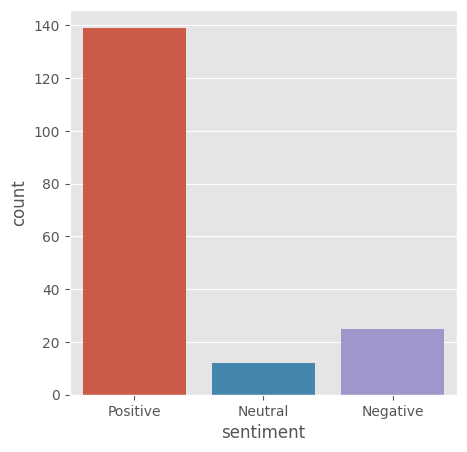

In [108]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = df_polarity)

Text(0.5, 1.0, 'Distribution of sentiments')

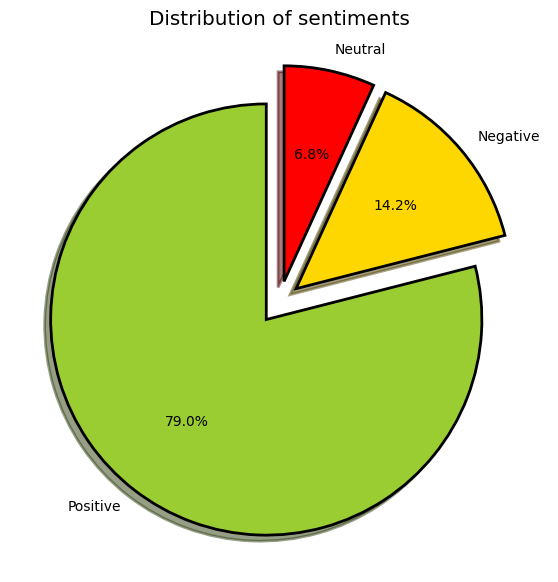

In [109]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df_polarity['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

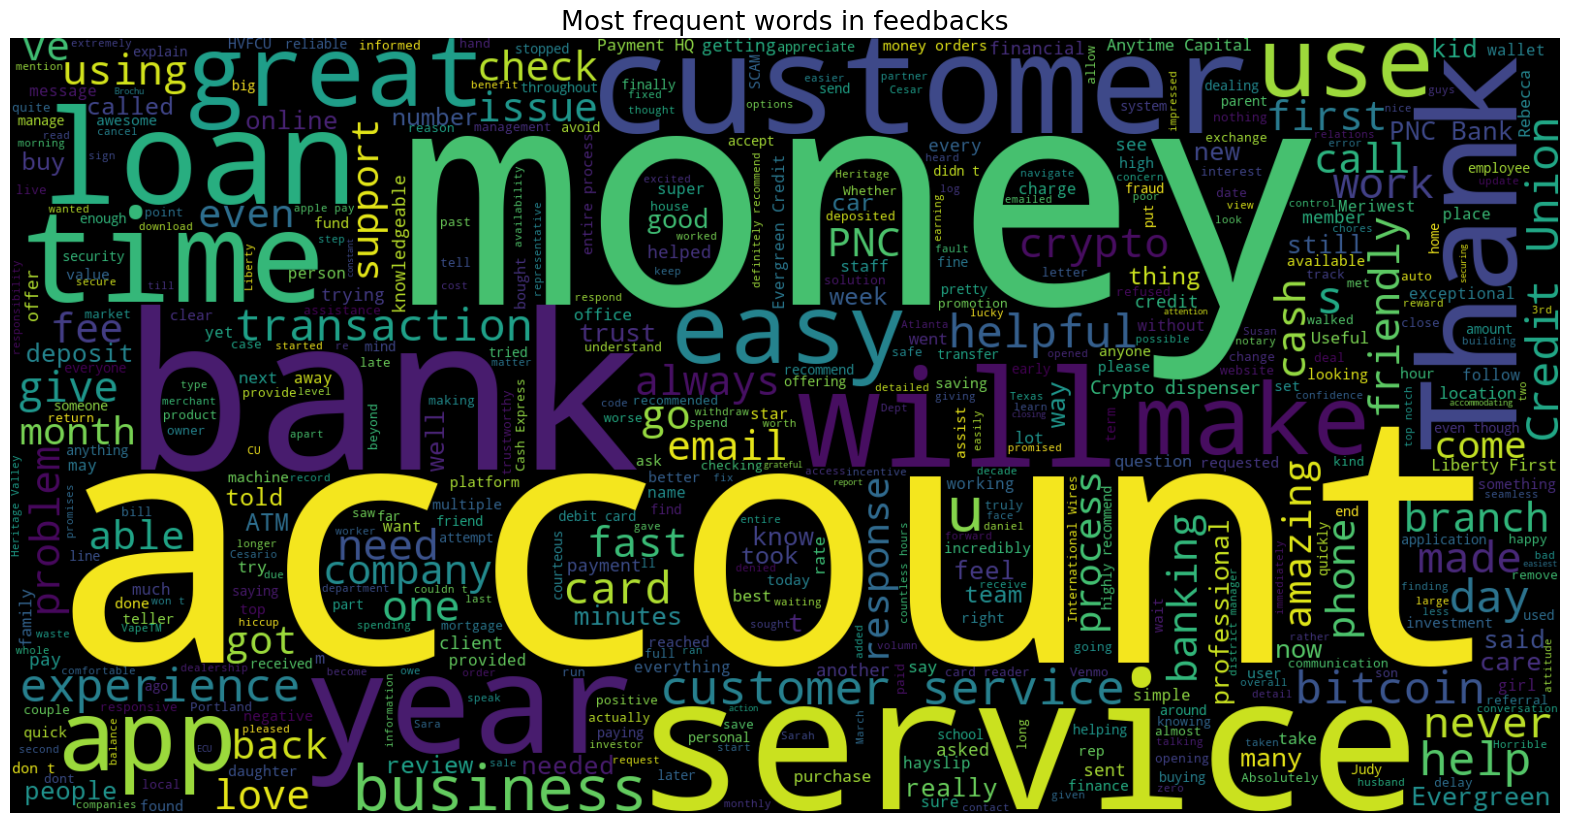

In [110]:
text = ' '.join([word for word in df_polarity['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in feedbacks', fontsize=19)
plt.show()